# Predicting Leads To Customers

Project Description: https://youtrack.geox.ws/issue/CR-138

# Import Modules

In [1]:
import os
import sys
from credentials import *
sys.path.append(project_path)
import warnings
import numpy as np
import pandas as pd
from PIL import Image
import seaborn as sns
import matplotlib as mpl
import missingno as msno
from matplotlib import colormaps
import matplotlib.pyplot as plt
from Queries.lead_queries import *
from urllib.request import urlopen
from ClassLibify.main import DataExtractor
from sklearn.linear_model import RidgeCV
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_validate
from sklearn.model_selection import TimeSeriesSplit

# Options and Settings

In [2]:
warnings.simplefilter("ignore")
mpl.rcParams["axes.grid"] = False
mpl.rcParams["figure.figsize"] = (8, 6)
np.set_printoptions(precision=4, suppress=True)
pd.options.plotting.matplotlib.register_converters = True

# Load Image

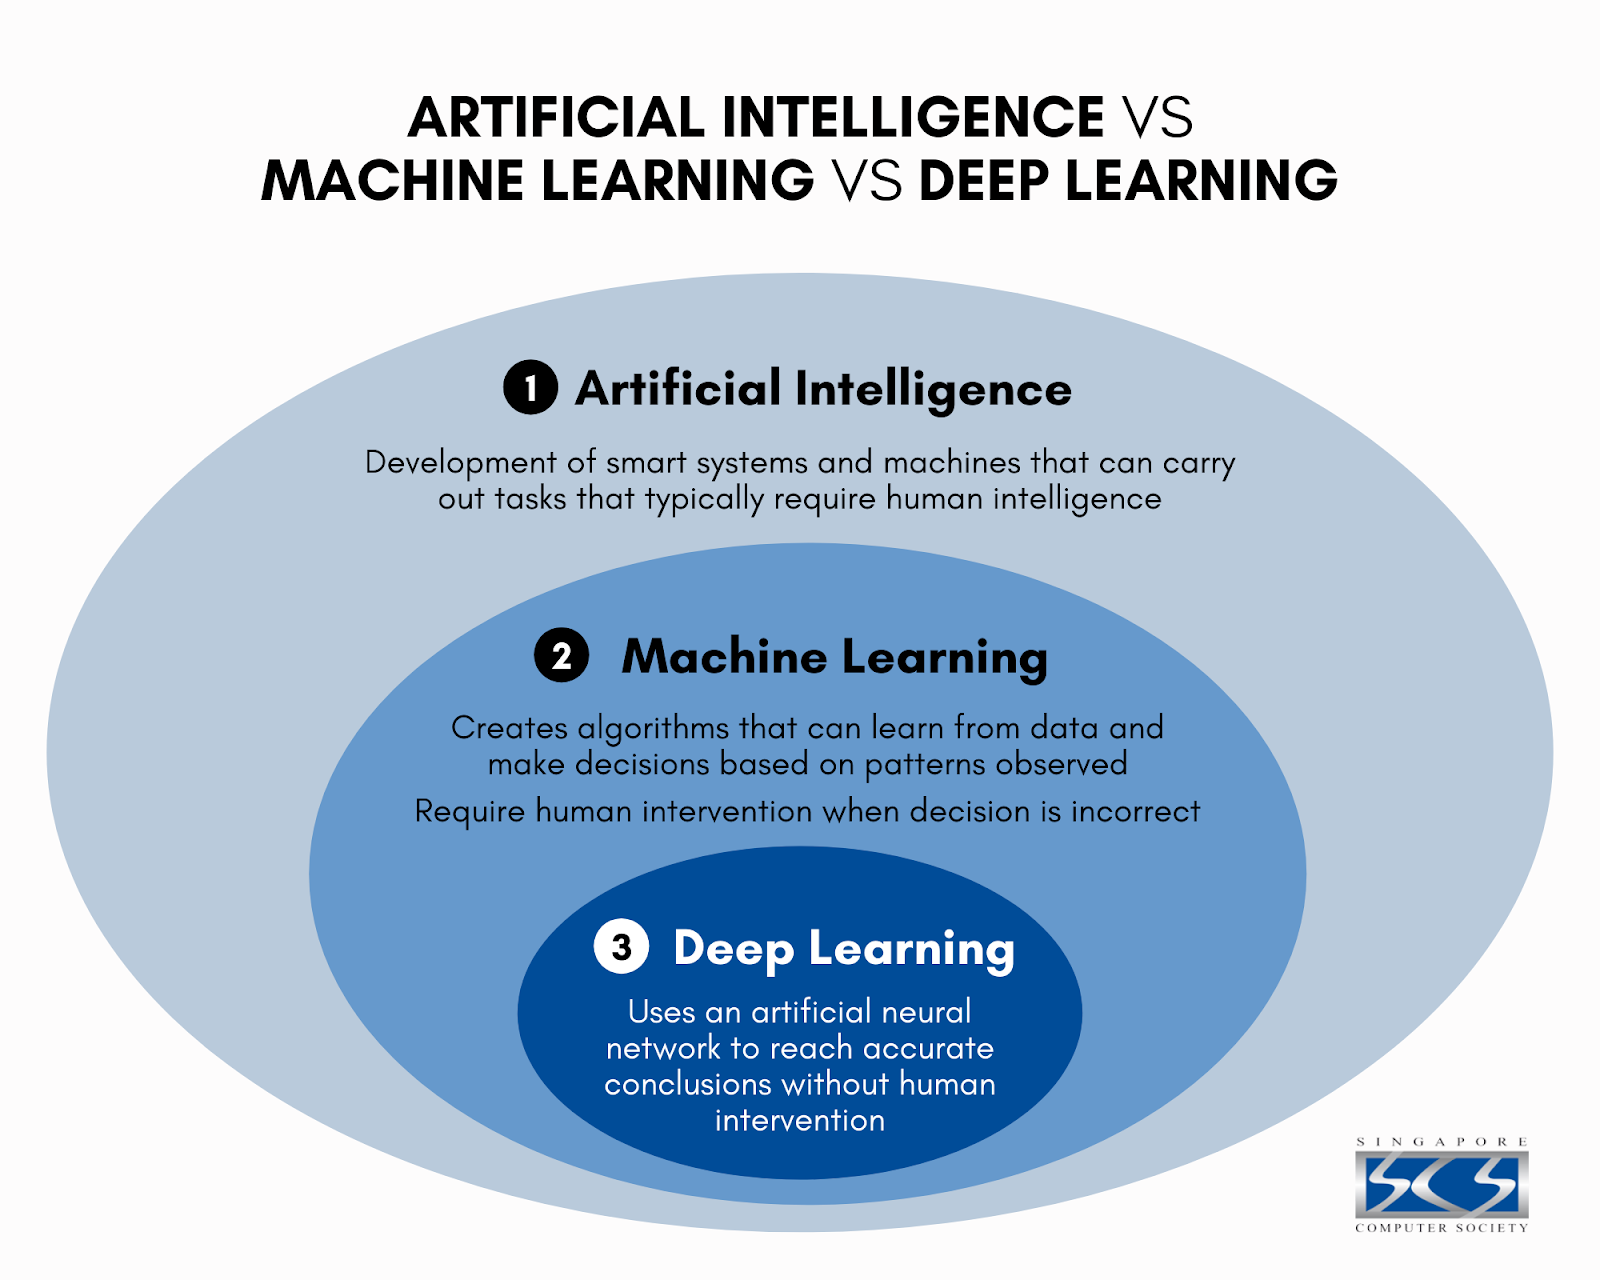

In [3]:
image_url = "https://s3.ap-southeast-1.amazonaws.com/files-scs-prod/public%2Fimages%2F1605842918803-AI+vs+ML+vs+DL.png"
Image.open(urlopen(image_url))

# Helper Functions

In [4]:
def fetch_db_data(sql_query: str, cols_to_use: list[str]):
  """
  Fetches data from Libify Databases

  Parameters
  ----------
  sql_query: str
    sql query to execute

  cols_to_use: list[str]
    list of column names to consider

  Returns:
      Pandas Dataframe

  """
  data = DataExtractor().get_data_repo_db(sql_query)

  return data[cols_to_use]



def cos_transformer(df: pd.DataFrame, period: int) -> pd.DataFrame:
  """
  Encode each of those periodic features using a cosine transformation with the matching period.

  Parameters
  ----------
  df: pd.DataFrame
    Pandas DataFrame

  period: int
    converts seconds within a given period. This could be hours, days, week and year
    example: seconds within a 24 hour period could be (24*60*60) thus 86,400

  Returns:
    Pandas DataFrame

  """
  df_copy = df.copy()

  df_ts = df_copy.assign(timestamp_sec=df_copy.select_dtypes(include="datetime64[ns]").map(pd.Timestamp.timestamp)).select_dtypes(exclude=["int64", "bool"])

  return np.cos(df_ts["timestamp_sec"] * (2 * np.pi) / period)



def sin_transformer(df: pd.DataFrame, period: int) -> pd.DataFrame:
  """
  Encode each of those periodic features using a sine transformation with the matching period.

  Parameters
  ----------
  df: pd.DataFrame
    Pandas DataFrame

  period: int
    converts seconds within a given period. This could be hours, days, week and year
    example: seconds within a 24 hour period could be (24*60*60) thus 86,400

  Returns:
    Pandas DataFrame

  """
  df_copy = df.copy()

  df_ts = df_copy.assign(timestamp_sec=df_copy.select_dtypes(include="datetime64[ns]").map(pd.Timestamp.timestamp)).select_dtypes(exclude=["int64", "bool"])

  return np.sin(df_ts["timestamp_sec"] * (2 * np.pi) / period)



def evaluate(model, X, y, cv, model_prop=None, model_step=None):
    """"
    Evaluate model 
    
    """
    cv_results = cross_validate(
        model,
        X,
        y,
        cv=cv,
        scoring=["neg_mean_absolute_error", "neg_root_mean_squared_error"],
        return_estimator=model_prop is not None,
    )
    if model_prop is not None:
        if model_step is not None:
            values = [
                getattr(m[model_step], model_prop) for m in cv_results["estimator"]
            ]
        else:
            values = [getattr(m, model_prop) for m in cv_results["estimator"]]
        print(f"Mean model.{model_prop} = {np.mean(values)}")
    mae = -cv_results["test_neg_mean_absolute_error"]
    rmse = -cv_results["test_neg_root_mean_squared_error"]
    print(
        f"Mean Absolute Error:     {mae.mean():.3f} +/- {mae.std():.3f}\n"
        f"Root Mean Squared Error: {rmse.mean():.3f} +/- {rmse.std():.3f}"
    )

# Extract Data

In [5]:
columns_to_use = ["lead_id", "lead_first_name", "lead_last_name", "aff_code", "lead_creat", "lead_creat_yr", "lead_creat_mnth", "lead_creat_mnth_name", 
                  "lead_creat_day", "lead_creat_day_name", "lead_status", "lead_reason", "cc_group", "lead_group", "is_creat", "campaign", "cust_id", 
                  "subsc_id", "subsc_start", "subsc_start_yr", "subsc_start_mnth", "subsc_start_mnth_name", "subsc_start_day", "subsc_start_day_name", 
                  "subsc_status",  "subsc_len_d", "prod", "is_acqui"]

df = fetch_db_data(query1, columns_to_use)

# Transform Extracted Data

In [6]:
columns_to_timestamp = ["lead_creat", "subsc_start"]
columns_integer = ["lead_creat_yr", "lead_creat_mnth", "lead_creat_day"]

# convert timestamp columns to pandas timestamp data types
df[columns_to_timestamp] = df[columns_to_timestamp].astype("datetime64[ns]")

# convert lead created year, month and day to integer
df[columns_integer] = df[columns_integer].astype("int32")

# Data Exploration

In [7]:
df.head(3)

lead_id lead_first_name lead_last_name  \
0  00101a54-91f5-4bac-b579-1982633760a0    Heinz-Werner           Loga   
1  004d6bab-c746-4b10-884c-5e7c58691e9d          Bianca        Kästner   
2  0253e8cf-3d76-451a-a18d-4023ab86aa02         Michael         Weller   

   aff_code lead_creat  lead_creat_yr  lead_creat_mnth lead_creat_mnth_name  \
0  DIPFLEGE 2019-05-06           2019                5                  May   
1  DIPFLEGE 2019-04-25           2019                4                  Apr   
2  DIPFLEGE 2019-04-17           2019                4                  Apr   

   lead_creat_day lead_creat_day_name  ... subsc_start subsc_start_yr  \
0               6                 Mon  ...  2019-05-20         2019.0   
1              25                 Thu  ...         NaT            NaN   
2              17                 Wed  ...         NaT            NaN   

  subsc_start_mnth subsc_start_mnth_name  subsc_start_day  \
0              5.0                   May             20.0   
1              NaN                  None              NaN   
2              NaN                  None              NaN   

  subsc_start_day_name  subsc_status  subsc_len_d   prod  is_acqui  
0                  Mon      canceled        832.0  Mobil         1  
1                 None          None          NaN   None         0  
2                 None          None          NaN   None         0  

[3 rows x 28 columns]

In [8]:
df.tail(3)

lead_id lead_first_name lead_last_name aff_code lead_creat  \
405395    None          Volker       Degethof  LIBIFYO 2018-09-14   
405396    None     xghmngfnfgn     dxbfbgdrgn  LIBIFYO 2018-09-15   
405397    None            None           None  LIBIFYO 2024-01-16   

        lead_creat_yr  lead_creat_mnth lead_creat_mnth_name  lead_creat_day  \
405395           2018                9                  Sep              14   
405396           2018                9                  Sep              15   
405397           2024                1                  Jan              16   

       lead_creat_day_name  ... subsc_start subsc_start_yr subsc_start_mnth  \
405395                 Fri  ...         NaT            NaN              NaN   
405396                 Sat  ...         NaT            NaN              NaN   
405397                 Tue  ...         NaT            NaN              NaN   

       subsc_start_mnth_name  subsc_start_day subsc_start_day_name  \
405395                  None              NaN                 None   
405396                  None              NaN                 None   
405397                  None              NaN                 None   

        subsc_status  subsc_len_d  prod  is_acqui  
405395          None          NaN  None         0  
405396          None          NaN  None         0  
405397          None          NaN  None         0  

[3 rows x 28 columns]

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 405398 entries, 0 to 405397
Data columns (total 28 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   lead_id                405354 non-null  object        
 1   lead_first_name        405175 non-null  object        
 2   lead_last_name         405172 non-null  object        
 3   aff_code               405398 non-null  object        
 4   lead_creat             405398 non-null  datetime64[ns]
 5   lead_creat_yr          405398 non-null  int32         
 6   lead_creat_mnth        405398 non-null  int32         
 7   lead_creat_mnth_name   405398 non-null  object        
 8   lead_creat_day         405398 non-null  int32         
 9   lead_creat_day_name    405398 non-null  object        
 10  lead_status            405398 non-null  object        
 11  lead_reason            126058 non-null  object        
 12  cc_group               405398 non-null  obje

In [10]:
df.describe().transpose()    

count                           mean  \
lead_creat          405398  2020-12-31 04:14:25.638212096   
lead_creat_yr     405398.0                    2020.473525   
lead_creat_mnth   405398.0                       6.840621   
lead_creat_day    405398.0                      15.743965   
is_creat          405398.0                       0.912849   
cust_id            77532.0                 2054284.912062   
subsc_id           77532.0                  1343410.69312   
subsc_start          77532  2020-09-27 16:19:45.698808064   
subsc_start_yr     77532.0                    2020.263943   
subsc_start_mnth   77532.0                       6.231195   
subsc_start_day    77532.0                      16.452948   
subsc_len_d        77532.0                     429.940321   
is_acqui          405398.0                       0.161856   

                                  min                  25%  \
lead_creat        2014-11-22 00:00:00  2018-09-25 00:00:00   
lead_creat_yr                  2014.0               2018.0   
lead_creat_mnth                   1.0                  4.0   
lead_creat_day                    1.0                 10.0   
is_creat                          0.0                  1.0   
cust_id                     1375718.0            1842604.5   
subsc_id                     765490.0            1102490.0   
subsc_start       2014-11-22 00:00:00  2018-09-30 00:00:00   
subsc_start_yr                 2014.0               2018.0   
subsc_start_mnth                  1.0                  3.0   
subsc_start_day                   1.0                  9.0   
subsc_len_d                       0.0                 25.0   
is_acqui                          0.0                  0.0   

                                  50%                  75%  \
lead_creat        2021-02-02 00:00:00  2022-11-07 00:00:00   
lead_creat_yr                  2021.0               2022.0   
lead_creat_mnth                   8.0                  9.0   
lead_creat_day                   15.0                 21.0   
is_creat                          1.0                  1.0   
cust_id                     2133680.5           2228319.25   
subsc_id                    1381927.5           1592334.75   
subsc_start       2020-09-28 00:00:00  2022-09-13 00:00:00   
subsc_start_yr                 2020.0               2022.0   
subsc_start_mnth                  6.0                  9.0   
subsc_start_day                  16.0                 24.0   
subsc_len_d                     201.0               669.25   
is_acqui                          0.0                  0.0   

                                  max            std  
lead_creat        2024-03-28 00:00:00            NaN  
lead_creat_yr                  2024.0       2.077722  
lead_creat_mnth                  12.0       3.372814  
lead_creat_day                   31.0        7.86553  
is_creat                          1.0       0.282057  
cust_id                     2405661.0  242324.534812  
subsc_id                    1707783.0  255493.156154  
subsc_start       2024-03-28 00:00:00            NaN  
subsc_start_yr                 2024.0       2.115522  
subsc_start_mnth                 12.0        3.44048  
subsc_start_day                  31.0       8.587674  
subsc_len_d                    2900.0     533.549058  
is_acqui                          1.0       0.368319

# Data Visualization

Returns The Total Lead Count Grouped By Year and Call Center

In [11]:
df[["lead_creat_yr", "cc_group", "is_creat"]]\
  .query("is_creat == 1")\
    .groupby(["lead_creat_yr", "cc_group"])\
      .count()\
        .rename(columns={"is_creat": "Lead Count"})

Lead Count
lead_creat_yr cc_group                                
2014          Sonstige                               7
2015          Sonstige                               6
2016          Sonstige                             133
              Telepower                              6
2017          Libify                                 9
              Sonstige                            2868
              Telepower                            164
2018          Covendos                            2573
              Epfortuna                           2556
              KM Co                                568
              Libify                               730
              Sonstige                           56297
              Telepower                          28177
2019          Comcare                                2
              Covendos                            5093
              Epfortuna                            781
              KM Co                               1383
              Libify                              1342
              Libify Owned and Operated/PM           2
              Sonstige                           18405
              Telepower                           7097
2020          Comcare                              251
              Covendos                            6725
              KM Co                              18595
              Libify                              2102
              Sonstige                            7179
              Telepower                            593
              lfk                                    1
2021          Comcare                             1141
              Covendos                           11025
              KM Co                              37233
              Libify                              5553
              Sonstige                             518
              lfk                                  126
2022          Covendos                            5385
              KM Co                              26557
              Libify                              8274
              Sonstige                             926
              lfk                                16670
2023          Covendos                              64
              KM Co                               7119
              Libify                              7184
              Sonstige                             406
              lfk                                54407
2024          KM Co                               2320
              Libify                              2239
              Sonstige                             151
              lfk                                19124

<Axes: title={'center': 'Total Lead Count By Year'}, xlabel='Lead Count', ylabel='Year'>

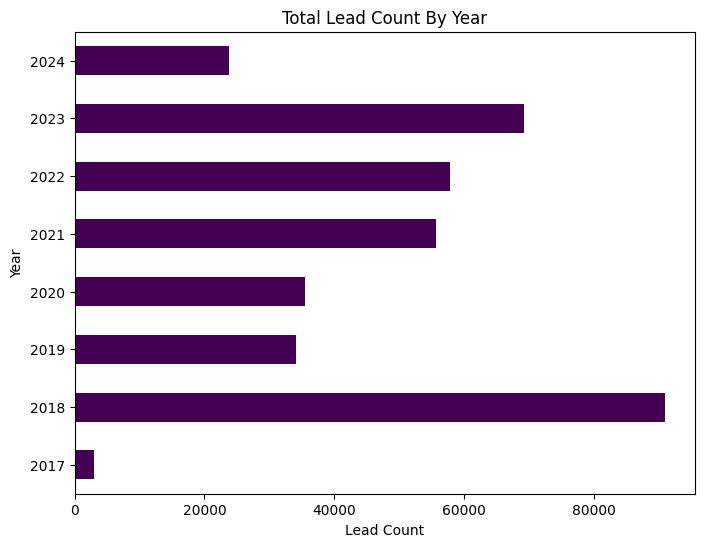

In [12]:
df[["lead_creat_yr", "is_creat"]]\
  .query("is_creat == 1 & lead_creat_yr >= 2017")\
    .groupby("lead_creat_yr")\
      .count()\
          .plot(kind="barh", xlabel="Lead Count", ylabel="Year", title="Total Lead Count By Year", colormap=list(colormaps)[3], legend=False)

Returns The Total Count Of Leads Grouped By Year, Month and Call Center 

In [13]:
df[["lead_creat_yr", "lead_creat_mnth_name", "cc_group", "is_creat"]]\
  .query("is_creat == 1")\
    .groupby(["lead_creat_yr", "lead_creat_mnth_name", "cc_group"])\
      .count()\
        .rename(columns={"is_creat": "Lead Count"})

Lead Count
lead_creat_yr lead_creat_mnth_name cc_group            
2014          Dec                  Sonstige           3
              Nov                  Sonstige           4
2015          Dec                  Sonstige           1
              Nov                  Sonstige           1
              Oct                  Sonstige           2
...                                                 ...
2024          Jan                  lfk             7390
              Mar                  KM Co            947
                                   Libify           636
                                   Sonstige          38
                                   lfk             5584

[414 rows x 1 columns]

Returns The Overall Lead Count By Month

<Axes: xlabel='Month', ylabel='Count'>

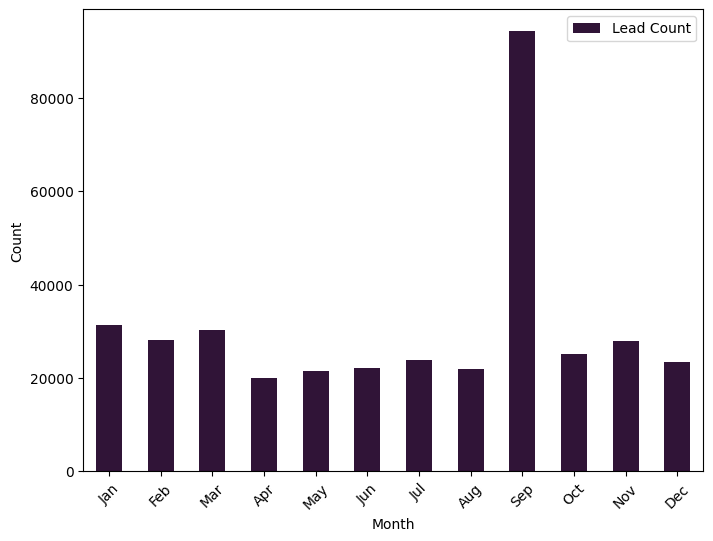

In [14]:
months_ordered = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

df[["lead_creat_mnth_name", "is_creat"]]\
  .query("is_creat == 1")\
    .groupby("lead_creat_mnth_name")\
      .count()\
        .reindex(months_ordered)\
          .rename(columns={"is_creat": "Lead Count"})\
            .plot(kind="bar", xlabel="Month", ylabel="Count", rot=45, colormap=list(colormaps)[6])

Returns Lead Count By Call Center

In [15]:
df[["cc_group", "is_creat"]]\
  .query("is_creat == 1")\
    .groupby("cc_group")\
      .count()\
        .rename(columns={"is_creat": "Lead Count"})\
          .sort_values(by="Lead Count", ascending=False)

Lead Count
cc_group                                
KM Co                              93775
lfk                                90328
Sonstige                           86896
Telepower                          36037
Covendos                           30865
Libify                             27433
Epfortuna                           3337
Comcare                             1394
Libify Owned and Operated/PM           2

In [16]:
df[["cc_group", "is_creat"]]\
  .query("is_creat == 1")\
    .groupby("cc_group")\
      .count()\
        .rename(columns={"is_creat": "Lead Count"})\
          .sort_values(by="Lead Count", ascending=False)\
            .plot(kind="pie", y="Lead Count", figsize=(20, 14), autopct="%.1f", title="Proportion Of Lead Count By Call Center")

<Axes: title={'center': 'Proportion Of Lead Count By Call Center'}, ylabel='Lead Count'>

Returns Lead Count By Lead Group

In [17]:
df[["lead_group", "is_creat"]]\
  .query("is_creat == 1")\
    .groupby("lead_group")\
      .count()\
        .rename(columns={"is_creat": "Lead Count"})\
          .sort_values(by="Lead Count", ascending=False)

Lead Count
lead_group                       
Performance Marketing      257549
Online Extern               44335
Schrankfertig               28584
Organic Marketing           24598
Partner Marketing            4399
Offline Campaign             1533
Online Libify                  99
lokaler Markt                  39

<Axes: title={'center': 'Lead Count By Lead Group'}, xlabel='Lead Group', ylabel='Total Count'>

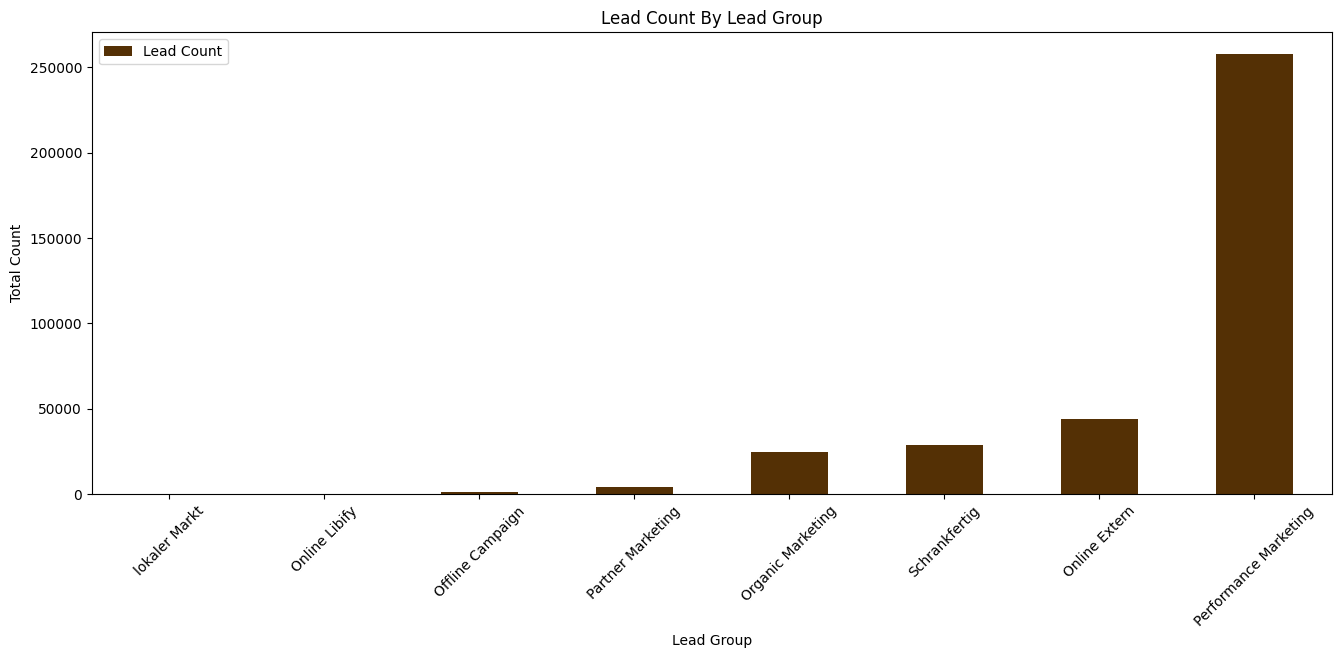

In [18]:
df[["lead_group", "is_creat"]]\
  .query("is_creat == 1")\
    .groupby("lead_group")\
      .count()\
        .rename(columns={"is_creat": "Lead Count"})\
          .sort_values(by="Lead Count", ascending=True)\
            .plot(kind="bar", xlabel="Lead Group", ylabel="Total Count", title="Lead Count By Lead Group", rot=45, colormap=list(colormaps)[9], figsize=(16, 6))

Returns Lead Count By Campaign

In [19]:
df[["campaign", "is_creat"]]\
  .query("is_creat == 1")\
    .groupby("campaign")\
      .count()\
        .rename(columns={"is_creat": "Lead Count"})\
          .sort_values(by="Lead Count", ascending=False)

Lead Count
campaign                                                      
Verband Pflegehilfe                                     124982
Käuferportal                                             39945
Pflege.de                                                28878
Hausfrage                                                26699
EP-Fortuna                                               24745
...                                                        ...
Matthias Delfs und Pasqual Stille GbR                        1
Pflegedienst Neef                                            1
Caritas-Sozialstation St. Franziskus e.V. Gemünden           1
Carekonzept Pfelgeberatung                                   1
DEIN Pflegedienst - Sören Nissen GbR                         1

[243 rows x 1 columns]

<Axes: title={'center': 'Lead Count By Campaign (Top 10)'}, xlabel='Campaign', ylabel='Lead Count'>

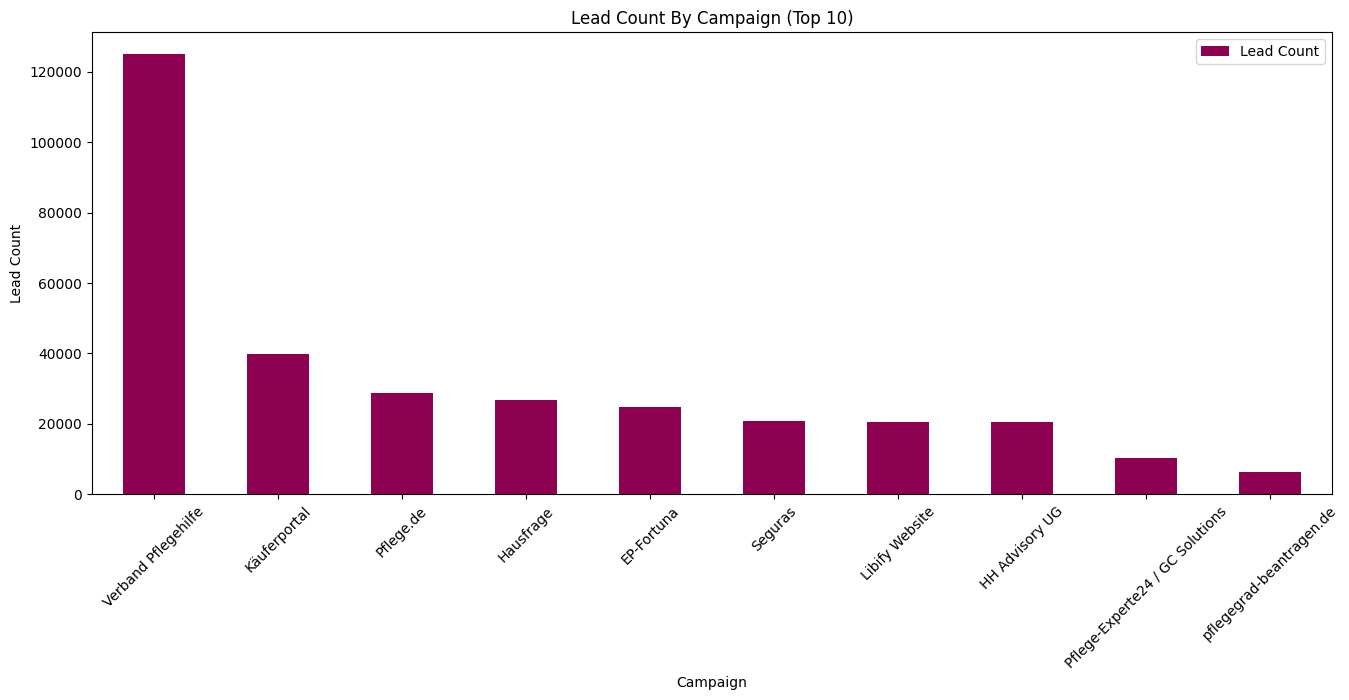

In [20]:
df[["campaign", "is_creat"]]\
  .query("is_creat == 1")\
    .groupby("campaign")\
      .count()\
        .rename(columns={"is_creat": "Lead Count"})\
          .sort_values(by="Lead Count", ascending=False)[:10]\
            .plot(kind="bar", xlabel="Campaign", ylabel="Lead Count", title="Lead Count By Campaign (Top 10)", rot=45, colormap=list(colormaps)[19], figsize=(16, 6))

# Feature Engineering

Step_1 ==> Select Columns To Use For Model Prediction\
Step_2 ==> Filter Only Qualified Leads And Cases Where Lead Was First Created, Thus Eliminate Duplicated Leads\
Step_3 ==> Sample Lead Created Dates On An Hourly Basis\
Step_4 ==> Sample Leads Created Beginning 1st January 2016 

In [21]:
is_lead_created = 1
lead_status = "qualified"
lead_created_date = '2016-01-01'
sampling_rule = "1H"
aggregates = {
               "aff_code": "nunique", 
               "cc_group": "nunique", 
               "lead_group": "nunique", 
               "campaign": "nunique", 
               "is_creat": "sum", 
               "is_acqui": "sum"
             }

fe_cols = ["lead_creat", "aff_code", "lead_status", "cc_group", "lead_group", "campaign", "is_creat", "is_acqui"]

df_fe = df[fe_cols]\
          .query("is_creat == @is_lead_created & lead_status == @lead_status & lead_creat >= @lead_created_date")\
            .set_index("lead_creat")\
              .resample(sampling_rule)\
                .agg(aggregates)\
                  .reset_index()

df_fe.head()

lead_creat  aff_code  cc_group  lead_group  campaign  is_creat  \
0 2016-01-10 00:00:00         1         1           1         1         1   
1 2016-01-10 01:00:00         0         0           0         0         0   
2 2016-01-10 02:00:00         0         0           0         0         0   
3 2016-01-10 03:00:00         0         0           0         0         0   
4 2016-01-10 04:00:00         0         0           0         0         0   

   is_acqui  
0         1  
1         0  
2         0  
3         0  
4         0

Step_5 ==> Check Missing Values For Feature DataFrame

In [22]:
df_fe.isnull().sum()

lead_creat    0
aff_code      0
cc_group      0
lead_group    0
campaign      0
is_creat      0
is_acqui      0
dtype: int64

In [23]:
msno.bar(df_fe, color="gray")

<Axes: >

Step_6 ==> Select Feature and Target Columns

In [24]:
feat_cols = ["lead_creat", "aff_code", "cc_group",	"lead_group",	"campaign",	"is_creat"]
tgt_col = "is_acqui"

X = df_fe[feat_cols]     
y = df_fe[tgt_col]    

# Time-based cross-validation

Use a time-sensitive cross-validation splitter to evaluate acquisition forecasting model as realistically as possible.\
Use a gap of 2 days between the train and test side of the splits.\
Limit the training set size to make the performance of the CV folds more stable.

In [25]:
ts_cv = TimeSeriesSplit(
                          n_splits=5,
                          max_train_size=1_000,
                          test_size=1_000,
                          gap=2
                       )
ts_cv

TimeSeriesSplit(gap=2, max_train_size=1000, n_splits=5, test_size=1000)

In [26]:
all_splits = list(ts_cv.split(X, y))

train_0, test_0 = all_splits[0]
train_4, test_4 = all_splits[4]

Inspect First Split

In [27]:
X.iloc[train_0]

lead_creat  aff_code  cc_group  lead_group  campaign  is_creat
65999 2023-07-21 23:00:00         0         0           0         0         0
66000 2023-07-22 00:00:00         3         3           1         3        20
66001 2023-07-22 01:00:00         0         0           0         0         0
66002 2023-07-22 02:00:00         0         0           0         0         0
66003 2023-07-22 03:00:00         0         0           0         0         0
...                   ...       ...       ...         ...       ...       ...
66994 2023-09-01 10:00:00         0         0           0         0         0
66995 2023-09-01 11:00:00         0         0           0         0         0
66996 2023-09-01 12:00:00         0         0           0         0         0
66997 2023-09-01 13:00:00         0         0           0         0         0
66998 2023-09-01 14:00:00         0         0           0         0         0

[1000 rows x 6 columns]

In [28]:
X.iloc[test_0]

lead_creat  aff_code  cc_group  lead_group  campaign  is_creat
67001 2023-09-01 17:00:00         0         0           0         0         0
67002 2023-09-01 18:00:00         0         0           0         0         0
67003 2023-09-01 19:00:00         0         0           0         0         0
67004 2023-09-01 20:00:00         0         0           0         0         0
67005 2023-09-01 21:00:00         0         0           0         0         0
...                   ...       ...       ...         ...       ...       ...
67996 2023-10-13 04:00:00         0         0           0         0         0
67997 2023-10-13 05:00:00         0         0           0         0         0
67998 2023-10-13 06:00:00         0         0           0         0         0
67999 2023-10-13 07:00:00         0         0           0         0         0
68000 2023-10-13 08:00:00         0         0           0         0         0

[1000 rows x 6 columns]

# Feature Preprocessing

Transform Datetime features\
Normalize numeric features

In [29]:
secs_in_day = 24 * 60 * 60
secs_in_year = np.multiply(365.2425, secs_in_day)

X["day_sin"] = sin_transformer(X, period=secs_in_day)
X["year_sin"] = sin_transformer(X, period=secs_in_year)

X["day_cos"] = cos_transformer(X, period=secs_in_day)
X["year_cos"] = cos_transformer(X, period=secs_in_year)

X[["day_sin", "year_sin", "day_cos", "year_cos"]].describe().transpose()

count          mean       std  min       25%           50%  \
day_sin   72001.0  1.611849e-15  0.707107 -1.0 -0.707107 -1.801471e-14   
year_sin  72001.0  1.769344e-02  0.707400 -1.0 -0.692113  4.195529e-02   
day_cos   72001.0  1.388870e-05  0.707117 -1.0 -0.707107  1.353356e-14   
year_cos  72001.0  1.639129e-02  0.706412 -1.0 -0.692069  4.201616e-02   

               75%  max  
day_sin   0.707107  1.0  
year_sin  0.722506  1.0  
day_cos   0.707107  1.0  
year_cos  0.719349  1.0

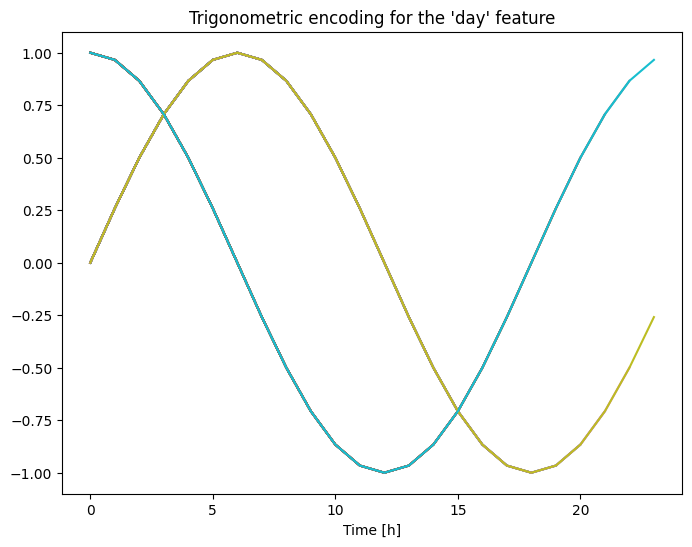

In [30]:
fig, ax = plt.subplots()

for _ in range(25):
    plt.plot(np.array(X["day_sin"])[:_])
    plt.plot(np.array(X["day_cos"])[:_])
    ax.set(title="Trigonometric encoding for the 'day' feature", xlabel="Time [h]")

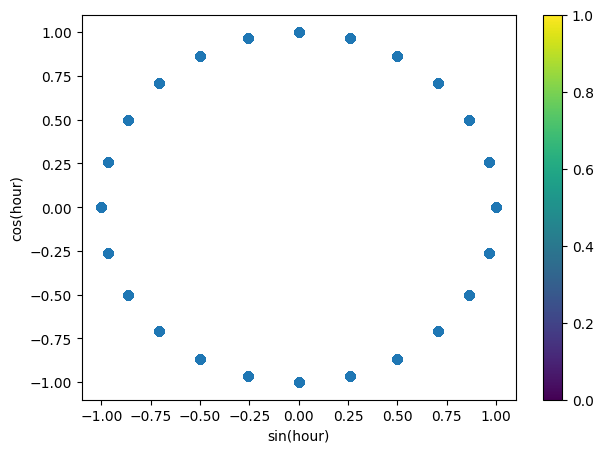

In [31]:
fig, ax = plt.subplots(figsize=(7, 5))
sp = ax.scatter(X["day_sin"], X["day_cos"])
ax.set(
    xlabel="sin(hour)",
    ylabel="cos(hour)",
)
_ = fig.colorbar(sp)

In [32]:
numeric_columns = X.select_dtypes(include="int64").columns
datetime_columns = X.select_dtypes(include="float64").columns

print("Numeric features:", numeric_columns.tolist())
print("Datetime features:", datetime_columns.tolist())

Numeric features: ['aff_code', 'cc_group', 'lead_group', 'campaign', 'is_creat']
Datetime features: ['day_sin', 'year_sin', 'day_cos', 'year_cos']


# Ridge Linear Model

In [33]:
ridge_alphas = np.logspace(-6, 6, 25)

ridge_pipeline = make_pipeline(
                                 ColumnTransformer(
                                                     transformers=[
                                                                     ("numeric_preprocess", MinMaxScaler(), numeric_columns)
                                                                  ]
                                                  ),
                                                  RidgeCV(alphas=ridge_alphas)
                              )
ridge_pipeline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('numeric_preprocess',
                                                  MinMaxScaler(),
                                                  Index(['aff_code', 'cc_group', 'lead_group', 'campaign', 'is_creat'], dtype='object'))])),
                ('ridgecv',
                 RidgeCV(alphas=array([      0.    ,       0.    ,       0.    ,       0.    ,
             0.0001,       0.0003,       0.001 ,       0.0032,
             0.01  ,       0.0316,       0.1   ,       0.3162,
             1.    ,       3.1623,      10.    ,      31.6228,
           100.    ,     316.2278,    1000.    ,    3162.2777,
         10000.    ,   31622.7766,  100000.    ,  316227.766 ,
       1000000.    ])))])

Return the coefficient of determination of the prediction.

In [34]:
ridge_score = ridge_pipeline.fit(X, y)
ridge_score.score(X.iloc[train_0], y.iloc[train_0]) 

0.9025973453912577

In [35]:
evaluate(ridge_pipeline, X, y, cv=ts_cv, model_prop="alpha_", model_step="ridgecv")

Mean model.alpha_ = 0.0532815661727072
Mean Absolute Error:     0.284 +/- 0.080
Root Mean Squared Error: 1.896 +/- 0.612


# Impact of features on linear model predictions

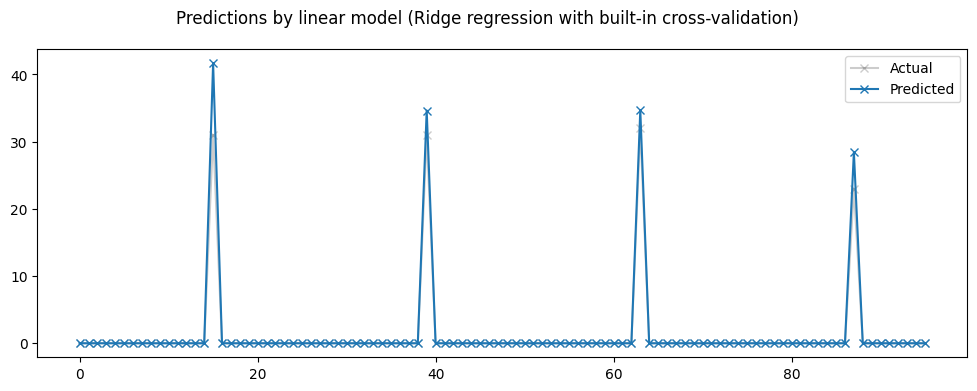

In [36]:
ridge_pipeline.fit(X.iloc[train_0], y.iloc[train_0])
naive_linear_predictions = ridge_pipeline.predict(X.iloc[test_0])

last_hours = slice(-96, None)                              # explore test and predicted values of the last 4 days   

fig, ax = plt.subplots(figsize=(12, 4))
fig.suptitle("Predictions by linear model (Ridge regression with built-in cross-validation)")

ax.plot(y.iloc[test_0].values[last_hours], "x-", alpha=0.2, label="Actual", color="black")
ax.plot(naive_linear_predictions[last_hours], "x-", label="Predicted")

_ = ax.legend()

In [37]:
ridge_pipeline[:-1].transform(X).shape               # returns the number of features extracted by each feature engineering pipeline

(72001, 5)